# Feature Engineering
## Imports & Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

## Load Dataset
First we read the CSV file and preview its contents with `head()`.

In [2]:
df = pd.read_csv('US_Accidents_March23_sampled_500k.csv')
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,...,False,False,False,False,True,False,Day,Day,Day,Day
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,...,False,False,False,False,True,False,Day,Day,Day,Day
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,...,False,False,False,False,False,False,Night,Night,Night,Night


Next we take a look at all the features it has and the initial number.

In [3]:
def check_features(data):
    print('Columns:', data.columns)
    print('Count:', len(data.columns))

check_features(df)

Columns: Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')
Count: 46


We're a long way from 150+ but we can use feature engineering to work with it.

## Feature Engineering

### Pruning
Although we're looking to get our feature numbers up, we need to first remove features that are completely irrelevant to our project. At a glance, `ID` and `Source` are purely metadata and don't contribute any information to the accidents themselves. Therefore they can be removed from our dataset.

In [4]:
irrelevant_features = [
    'ID',
    'Source'
]

df.drop(columns=irrelevant_features, inplace=True)

### One-Hot Encoding
There's a lot of categorical columns here that need to be encoded as numerical
so our ML models can train on our data more easily and accurately. The main way
we will do this is with one-hot encoding, which splits the categorical columns
into a binary column for each possible value.

At a glance, some columns that should be one-hot encoded are `State`, `Timezone`, and `Weather_Condition`.

In [5]:
df = pd.get_dummies(df, columns=['State', 'Weather_Condition'])
check_features(df)

Columns: Index(['Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street',
       ...
       'Weather_Condition_Thunder and Hail',
       'Weather_Condition_Thunder in the Vicinity',
       'Weather_Condition_Thunderstorm',
       'Weather_Condition_Thunderstorms and Rain', 'Weather_Condition_Tornado',
       'Weather_Condition_Volcanic Ash', 'Weather_Condition_Widespread Dust',
       'Weather_Condition_Widespread Dust / Windy',
       'Weather_Condition_Wintry Mix', 'Weather_Condition_Wintry Mix / Windy'],
      dtype='object', length=199)
Count: 199


### Datetime
Currently, we have start and end times encoded as `mm/dd/yyyy hh:mm:ss`. However, some timestamps have milliseconds while others do not (ex: `2022-12-03 23:37:14.000000000`). Since most of these millisecond values are just 0's, we'll just remove millisecond measures and restrict timestamp precision to just seconds.


In [6]:
df.rename(columns={'Start_Time': 'Start_Datetime', 'End_Time': 'End_Datetime'}, inplace=True)

def remove_milliseconds(datetime_str):
    if '.' in datetime_str:
        datetime_str = datetime_str.split('.')[0]
    return datetime_str

df['Start_Datetime'] = [remove_milliseconds(time) for time in df['Start_Datetime']]
df['End_Datetime'] = [remove_milliseconds(time) for time in df['End_Datetime']]

df.head()

,Severity,Start_Datetime,End_Datetime,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,...,Weather_Condition_Thunder and Hail,Weather_Condition_Thunder in the Vicinity,Weather_Condition_Thunderstorm,Weather_Condition_Thunderstorms and Rain,Weather_Condition_Tornado,Weather_Condition_Volcanic Ash,Weather_Condition_Widespread Dust,Weather_Condition_Widespread Dust / Windy,Weather_Condition_Wintry Mix,Weather_Condition_Wintry Mix / Windy
0,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,Accident on LA-19 Baker-Zachary Hwy at Lower Z...,Highway 19,...,False,False,False,False,False,False,False,False,False,False
1,2,2022-12-03 23:37:14,2022-12-04 01:56:53,38.990562,-77.399070,38.990037,-77.398282,0.056,Incident on FOREST RIDGE DR near PEPPERIDGE PL...,Forest Ridge Dr,...,False,False,False,False,False,False,False,False,False,False
2,2,2022-08-20 13:13:00,2022-08-20 15:22:45,34.661189,-120.492822,34.661189,-120.492442,0.022,Accident on W Central Ave from Floradale Ave t...,Floradale Ave,...,False,False,False,False,False,False,False,False,False,False
3,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,Incident on I-90 EB near REST AREA Drive with ...,14th St NW,...,False,False,False,False,False,False,False,False,True,False
4,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,RP ADV THEY LOCATED SUSP VEH OF 20002 - 726 CR...,River Blvd,...,False,False,False,False,False,False,False,False,False,False


Next, we will split off date and time into their own features to make it easier for analysis, especially since we care a lot more about time than date.

In [7]:
def get_date(datetime_str):
    return datetime_str.split()[0]

def get_time(datetime_str):
    return datetime_str.split()[1]

df['Start_Date'] = [get_date(datetime_str) for datetime_str in df['Start_Datetime']]
df['Start_Time'] = [get_time(datetime_str) for datetime_str in df['Start_Datetime']]
df['End_Date'] = [get_date(datetime_str) for datetime_str in df['End_Datetime']]
df['End_Time'] = [get_time(datetime_str) for datetime_str in df['End_Datetime']]

Finally, we can calculate the elapsed time and encode it in a new feature as well.

In [8]:
def calculate_elapsed_time(start_times, end_times, time_format='%Y-%m-%d %H:%M:%S'):
    elapsed_times = []
    for start, end in zip(start_times, start_times):
        start_dt = datetime.strptime(start, time_format)
        end_dt = datetime.strptime(end, time_format)
        elapsed_times.append(abs(end_dt - start_dt))
    return pd.Series(elapsed_times)

df['Elapsesd_Time'] = calculate_elapsed_time(df['Start_Datetime'], df['End_Datetime'])

Another feature we can encode is if the traffic accident ocurred on a weekday or weekend. We will check only the start date since we are most concerned with the moment the accident occurred.

In [9]:
df['Is_Weekend'] = pd.to_datetime(df['Start_Date']).dt.weekday >= 5
df.head()

,Severity,Start_Datetime,End_Datetime,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,...,Weather_Condition_Widespread Dust,Weather_Condition_Widespread Dust / Windy,Weather_Condition_Wintry Mix,Weather_Condition_Wintry Mix / Windy,Start_Date,Start_Time,End_Date,End_Time,Elapsesd_Time,Is_Weekend
0,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,Accident on LA-19 Baker-Zachary Hwy at Lower Z...,Highway 19,...,False,False,False,False,2019-06-12,10:10:56,2019-06-12,10:55:58,0 days,False
1,2,2022-12-03 23:37:14,2022-12-04 01:56:53,38.990562,-77.399070,38.990037,-77.398282,0.056,Incident on FOREST RIDGE DR near PEPPERIDGE PL...,Forest Ridge Dr,...,False,False,False,False,2022-12-03,23:37:14,2022-12-04,01:56:53,0 days,True
2,2,2022-08-20 13:13:00,2022-08-20 15:22:45,34.661189,-120.492822,34.661189,-120.492442,0.022,Accident on W Central Ave from Floradale Ave t...,Floradale Ave,...,False,False,False,False,2022-08-20,13:13:00,2022-08-20,15:22:45,0 days,True
3,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,Incident on I-90 EB near REST AREA Drive with ...,14th St NW,...,False,False,True,False,2022-02-21,17:43:04,2022-02-21,19:43:23,0 days,False
4,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,RP ADV THEY LOCATED SUSP VEH OF 20002 - 726 CR...,River Blvd,...,False,False,False,False,2020-12-04,01:46:00,2020-12-04,04:13:09,0 days,False


### Final Feature Count
Taking a look at our final feature count, we have:

In [10]:
check_features(df)

Columns: Index(['Severity', 'Start_Datetime', 'End_Datetime', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street',
       ...
       'Weather_Condition_Widespread Dust',
       'Weather_Condition_Widespread Dust / Windy',
       'Weather_Condition_Wintry Mix', 'Weather_Condition_Wintry Mix / Windy',
       'Start_Date', 'Start_Time', 'End_Date', 'End_Time', 'Elapsesd_Time',
       'Is_Weekend'],
      dtype='object', length=205)
Count: 205


## Numerical Analysis

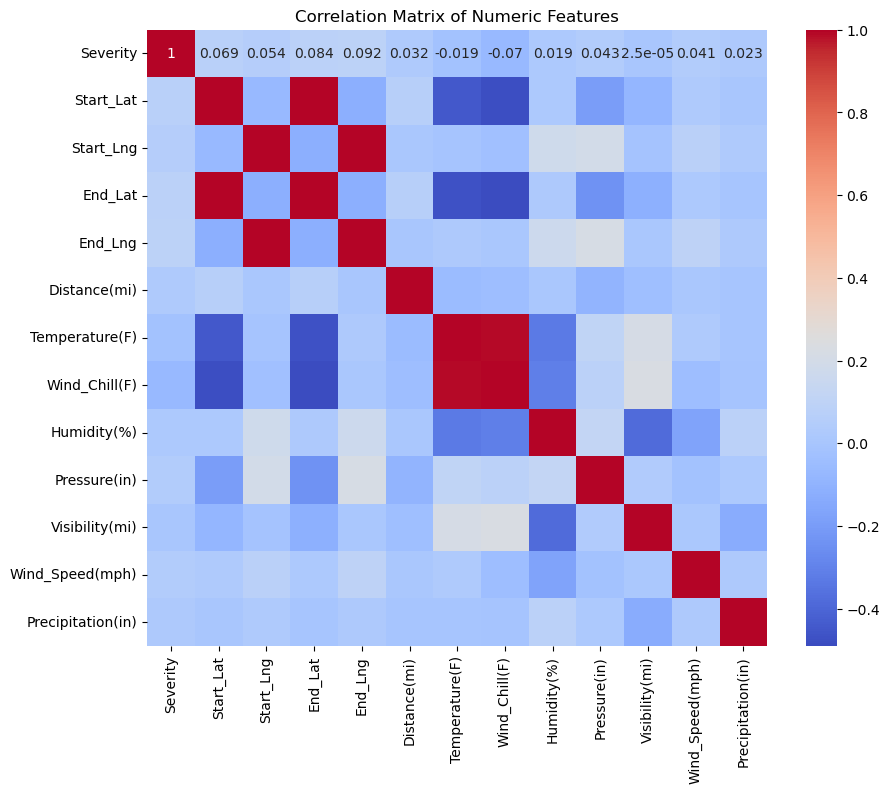

In [11]:
numeric_df = df.select_dtypes(include=[float, int]) # Select only numeric columns for correlation

corr_matrix = numeric_df.corr()
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Features")
plt.show()


In [12]:
from datetime import datetime

def calculate_elapsed_time(start_times, end_times, time_format='%Y-%m-%d %H:%M:%S'):
    elapsed_times = []
    for start, end in zip(start_times, end_times):
        try:
            start_dt = datetime.strptime(start, time_format)
            end_dt = datetime.strptime(end, time_format)
            elapsed_time = (end_dt - start_dt).total_seconds() / 60  # Convert to minutes
            elapsed_times.append(elapsed_time)
        except Exception as e:
            elapsed_times.append(None) 
    return pd.Series(elapsed_times)


if 'Start_Datetime' in df.columns and 'End_Datetime' in df.columns:
    df['Elapsed_Time'] = calculate_elapsed_time(df['Start_Datetime'], df['End_Datetime'])
else:
    print("Error: 'Start_Datetime' or 'End_Datetime' column is missing in the DataFrame.")


In [13]:
print(df[['Start_Datetime', 'End_Datetime', 'Elapsed_Time']].head())


        Start_Datetime         End_Datetime  Elapsed_Time
0  2019-06-12 10:10:56  2019-06-12 10:55:58     45.033333
1  2022-12-03 23:37:14  2022-12-04 01:56:53    139.650000
2  2022-08-20 13:13:00  2022-08-20 15:22:45    129.750000
3  2022-02-21 17:43:04  2022-02-21 19:43:23    120.316667
4  2020-12-04 01:46:00  2020-12-04 04:13:09    147.150000


## Visualization

/Users/kshitizdhakal/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


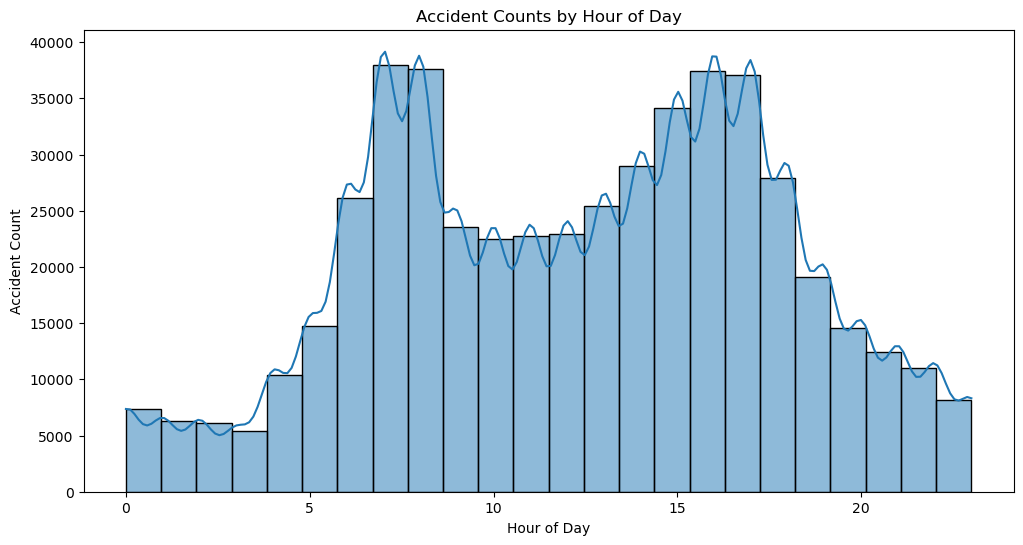

In [14]:
df['Hour'] = pd.to_datetime(df['Start_Datetime']).dt.hour
plt.figure(figsize=(12, 6))
sns.histplot(df['Hour'], bins=24, kde=True)
plt.title("Accident Counts by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Accident Count")
plt.show()

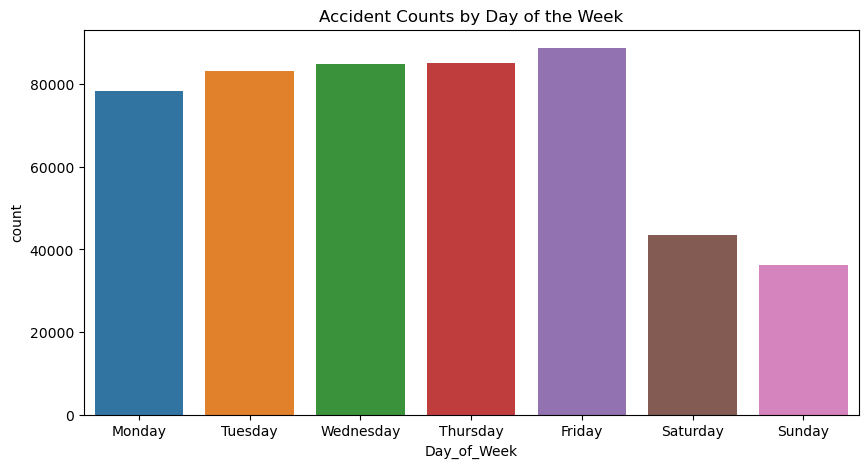

In [15]:
df['Day_of_Week'] = pd.to_datetime(df['Start_Date']).dt.day_name()
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Day_of_Week', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Accident Counts by Day of the Week")
plt.show()

In [16]:
df = df.dropna(subset=['Humidity(%)', 'Severity'])

X = df[['Humidity(%)']] # We can change the feature and target variables according to our purpose
y = df['Severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=100)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       825
           2       0.80      1.00      0.89     77873
           3       0.00      0.00      0.00     16530
           4       0.00      0.00      0.00      2546

    accuracy                           0.80     97774
   macro avg       0.20      0.25      0.22     97774
weighted avg       0.63      0.80      0.71     97774



/Users/kshitizdhakal/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kshitizdhakal/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kshitizdhakal/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
